In [118]:
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np
import plotly.express as px

# 0. Explicación

#### La base importada son datos de la demanda energética diaria desde 2007 a 2023 provenientes de Cammesa. La variable target (variable a predecir) es la demanda energética diaria, presente en la columna "Energía SADI (GWh)".

#### Las variables de entrada, tambien llamadas las "features" del modelo a realizar son:

##### -> Temperatura de ese día
##### -> Indicador de día hábil
##### -> Valor dólar oficial

#### Además, naturalmente se usarán las variables relacionadas a la fecha de cada registro, como número de dia de la semana, número de dia del año, número de mes del año, número de año.

#### Obviamente, se debe realizar una preparación y limpieza para que esos datos puedan ser procesados por las librerías utilizadas para elegir el modelo predictivo. Muchos de estos procesos implican transoformar variables categóricas en numéricas. Como lo haremos con la columna de Clima y TIPO DIA.

#### Cabe destacar que el modelo principal que buscamos es para predecir la demanda energética diaria en Argentina, sin embargo, para realizar el pronóstico a futuro con dicho modelo, será necesario alimentar al mismo con los valores futuros de las variables de entrada. Para esto será necesario realizar un pronóstico de las variables de entrada como la temperatura, el clima, y el indicador de día habil. Para ello se utilizará la librería Prophet, desarrollada por los ingenieros de Meta (Facebook), es una librería ideal y ampliamente utilizada para predecir series temporales univariadas.

##### Por lo tanto, en primer lugar realizaremos la preparación y limpieza del dataset, luego generaremos el dataset que contenga los valores futuros, calculados con prophet. Después utilizaremos la librería Pycaret para elegir el mejor modelo para predecir la demanda energética, luego entrenaremos ese modelo y realizaremos el pronóstico con los datos generados con Prophet.

# 1. Importación del dataset

In [119]:
data = pd.read_excel(r"./demandaHistorica.xlsx")
data

,FECHA,Energía SADI (GWh),Potencia Pico SADI (MW),DIA,TIPO DIA,VERANO / INVIERNO,T Media GBA (°C),Claro/Nublado/Seminublado
0,2007-01-01,277.581153,14157.0,Lunes,FERIADO,VERANO,29.2,C
1,2007-01-02,325.393852,15801.0,Martes,HÁBIL,VERANO,26.01,N
2,2007-01-03,325.492540,16136.0,Miércoles,HÁBIL,VERANO,25,N
3,2007-01-04,334.033576,16782.0,Jueves,HÁBIL,VERANO,25,N
4,2007-01-05,320.328528,15321.0,Viernes,HÁBIL,VERANO,22.6,C
...,...,...,...,...,...,...,...,...
6001,2023-06-07,399.412437,19646.0,Miércoles,HÁBIL,INVIERNO,18.4,N
6002,2023-06-08,391.938465,19004.0,Jueves,HÁBIL,INVIERNO,21.8,N
6003,2023-06-09,391.815378,19758.0,Viernes,HÁBIL,INVIERNO,18,N
6004,2023-06-10,405.336796,20424.0,Sábado,SÁBADO,INVIERNO,10.6,N


# 2. Limpieza y Preparación de los Datos

In [120]:
datos = data.copy()

datos["day_of_week"] = datos["FECHA"].dt.dayofweek
datos["day_of_year"] = datos["FECHA"].dt.dayofyear
datos["month"] = datos["FECHA"].dt.month
datos["year"] = datos["FECHA"].dt.year
datos['Series'] = np.arange(1,len(datos)+1)
datos = datos[["FECHA" ,"Series", "Energía SADI (GWh)", "T Media GBA (°C)", "day_of_week", "day_of_year", "month", "year", "TIPO DIA", "Claro/Nublado/Seminublado" ]]
datos["T Media GBA (°C)"] = datos["T Media GBA (°C)"].replace(',', '.', regex=True).astype(float)

datos.columns = ["date" ,"Series", "demand_GWh", "temperature_C", "day_of_week", "day_of_year", "month", "year", "is_working", "uv_index" ]
datos

,date,Series,demand_GWh,temperature_C,day_of_week,day_of_year,month,year,is_working,uv_index
0,2007-01-01,1,277.581153,29.20,0,1,1,2007,FERIADO,C
1,2007-01-02,2,325.393852,26.01,1,2,1,2007,HÁBIL,N
2,2007-01-03,3,325.492540,25.00,2,3,1,2007,HÁBIL,N
3,2007-01-04,4,334.033576,25.00,3,4,1,2007,HÁBIL,N
4,2007-01-05,5,320.328528,22.60,4,5,1,2007,HÁBIL,C
...,...,...,...,...,...,...,...,...,...,...
6001,2023-06-07,6002,399.412437,18.40,2,158,6,2023,HÁBIL,N
6002,2023-06-08,6003,391.938465,21.80,3,159,6,2023,HÁBIL,N
6003,2023-06-09,6004,391.815378,18.00,4,160,6,2023,HÁBIL,N
6004,2023-06-10,6005,405.336796,10.60,5,161,6,2023,SÁBADO,N


In [121]:
datos.is_working.value_counts()

HÁBIL      4046
SÁBADO      846
DOMINGO     840
FERIADO     274
Name: is_working, dtype: int64

In [122]:
datos.is_working = [1 if x == "HÁBIL" else 0 for x in datos.is_working]
datos.is_working.value_counts()

1    4046
0    1960
Name: is_working, dtype: int64

In [123]:
datos.uv_index.value_counts()

SN    2518
C     1862
N     1621
 C       3
C        2
Name: uv_index, dtype: int64

In [124]:
# Reemplazar los valores en la columna 'uv_index' según las condiciones dadas
datos['uv_index'] = datos['uv_index'].replace({'C': 3, 'SN': 2, 'N': 1})

# Verificar los cambios
print(datos['uv_index'].value_counts())

2     2518
3     1862
1     1621
 C       3
C        2
Name: uv_index, dtype: int64


In [125]:
datos['uv_index'] = datos['uv_index'].replace(' C', 3)
# Verificar los cambios
print(datos['uv_index'].value_counts())

2     2518
3     1865
1     1621
C        2
Name: uv_index, dtype: int64


In [126]:
datos['uv_index'] = datos['uv_index'].replace('C ', 3)
# Verificar los cambios
print(datos['uv_index'].value_counts())

2    2518
3    1867
1    1621
Name: uv_index, dtype: int64


In [127]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6006 entries, 0 to 6005
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           6006 non-null   datetime64[ns]
 1   Series         6006 non-null   int32         
 2   demand_GWh     6006 non-null   float64       
 3   temperature_C  6006 non-null   float64       
 4   day_of_week    6006 non-null   int64         
 5   day_of_year    6006 non-null   int64         
 6   month          6006 non-null   int64         
 7   year           6006 non-null   int64         
 8   is_working     6006 non-null   int64         
 9   uv_index       6006 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(6)
memory usage: 445.9 KB


In [128]:
datos

,date,Series,demand_GWh,temperature_C,day_of_week,day_of_year,month,year,is_working,uv_index
0,2007-01-01,1,277.581153,29.20,0,1,1,2007,0,3
1,2007-01-02,2,325.393852,26.01,1,2,1,2007,1,1
2,2007-01-03,3,325.492540,25.00,2,3,1,2007,1,1
3,2007-01-04,4,334.033576,25.00,3,4,1,2007,1,1
4,2007-01-05,5,320.328528,22.60,4,5,1,2007,1,3
...,...,...,...,...,...,...,...,...,...,...
6001,2023-06-07,6002,399.412437,18.40,2,158,6,2023,1,1
6002,2023-06-08,6003,391.938465,21.80,3,159,6,2023,1,1
6003,2023-06-09,6004,391.815378,18.00,4,160,6,2023,1,1
6004,2023-06-10,6005,405.336796,10.60,5,161,6,2023,0,1


##### Importamos datos históricos del valor del dólar oficial (fuente: BCRA)

In [12]:
# Cargar el DataFrame desde el archivo Excel
dolar = pd.read_excel(r"./CotizacionesBCRA.xlsx")

# Asegúrate de que la columna 'fecha' sea del tipo datetime
dolar['fecha'] = pd.to_datetime(dolar['fecha'])

# Eliminar duplicados basados en la columna 'fecha'
dolar = dolar.drop_duplicates(subset=['fecha'])

# Establecer las fechas como índice
dolar.set_index('fecha', inplace=True)

# Crear un rango de fechas desde el 1/1/2007 hasta el 11/06/2023
rango_fechas = pd.date_range(start='2007-01-01', end='2023-06-11', freq='D')

# Reindexar el DataFrame con el rango de fechas completo
dolar_reindexado = dolar.reindex(rango_fechas)

# Rellenar los valores faltantes utilizando el método forward fill (ffill)
dolar_reindexado['valor'] = dolar_reindexado['valor'].ffill()

# Si deseas guardar el resultado en un nuevo archivo CSV
# dolar_reindexado.to_csv('datos_actualizados.csv')

# Verificar el DataFrame actualizado
dolar_reindexado = dolar_reindexado.reset_index()
dolar_reindexado.info()
dolar_reindexado


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6006 entries, 0 to 6005
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   6006 non-null   datetime64[ns]
 1   valor   6006 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 94.0 KB


,index,valor
0,2007-01-01,3.058
1,2007-01-02,3.058
2,2007-01-03,3.059
3,2007-01-04,3.072
4,2007-01-05,3.078
...,...,...
6001,2023-06-07,243.500
6002,2023-06-08,244.450
6003,2023-06-09,244.950
6004,2023-06-10,244.950


In [13]:
datos = pd.concat([datos, dolar_reindexado.valor], axis=1)
datos.columns = ["date" ,"Series", "demand_GWh", "temperature_C", "day_of_week", "day_of_year", "month", "year", "is_working", "uv_index", "dolar_oficial" ]
datos

,date,Series,demand_GWh,temperature_C,day_of_week,day_of_year,month,year,is_working,uv_index,dolar_oficial
0,2007-01-01,1,277.581153,29.20,0,1,1,2007,0,3,3.058
1,2007-01-02,2,325.393852,26.01,1,2,1,2007,1,1,3.058
2,2007-01-03,3,325.492540,25.00,2,3,1,2007,1,1,3.059
3,2007-01-04,4,334.033576,25.00,3,4,1,2007,1,1,3.072
4,2007-01-05,5,320.328528,22.60,4,5,1,2007,1,3,3.078
...,...,...,...,...,...,...,...,...,...,...,...
6001,2023-06-07,6002,399.412437,18.40,2,158,6,2023,1,1,243.500
6002,2023-06-08,6003,391.938465,21.80,3,159,6,2023,1,1,244.450
6003,2023-06-09,6004,391.815378,18.00,4,160,6,2023,1,1,244.950
6004,2023-06-10,6005,405.336796,10.60,5,161,6,2023,0,1,244.950


##### Exportamos las series temporales de las features que serán input del modelo de demanda eléctrica, para predecir sus valores futuros con Prophet (En otro Notebook), y luego utilizarlos para generar el forecast de demanda eléctrica

In [36]:
serie_dolares = datos[["date", "dolar_oficial"]]
serie_temperatura = datos[["date", "temperature_C"]]
serie_feriados = datos[["date", "is_working"]]
serie_uv = datos[["date", "uv_index"]]

serie_dolares.to_excel(r"./prophet//serie_dolares.xlsx")
serie_temperatura.to_excel(r"./prophet//serie_temperatura.xlsx")
serie_feriados.to_excel(r"./prophet//serie_feriados.xlsx")
serie_uv.to_excel(r"./prophet//serie_uv.xlsx")


In [14]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6006 entries, 0 to 6005
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           6006 non-null   datetime64[ns]
 1   Series         6006 non-null   int32         
 2   demand_GWh     6006 non-null   float64       
 3   temperature_C  6006 non-null   float64       
 4   day_of_week    6006 non-null   int64         
 5   day_of_year    6006 non-null   int64         
 6   month          6006 non-null   int64         
 7   year           6006 non-null   int64         
 8   is_working     6006 non-null   int64         
 9   uv_index       6006 non-null   int64         
 10  dolar_oficial  6006 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(6)
memory usage: 492.8 KB


## Set Up del Regression Module de Pycaret

#### PyCaret Regression Module
PyCaret **Regression Module** is a supervised machine learning module used for estimating the relationships between a **dependent variable** (often called the ‘outcome variable’, or ‘target’) and one or more **independent variables** (often called ‘features’, or ‘predictors’).

The objective of regression is to predict continuous values such as sales amount, quantity, number of customers, etc. All modules in PyCaret provide many pre-processing features to prepare the data for modeling through the setup function. It has over 25 ready-to-use algorithms and several plots to analyze the performance of trained models.

#### Time Series With PyCaret Regression Module
PyCaret’s Regression module default settings are not ideal for time series data because it involves a few data preparatory steps that are not valid for ordered data (data with a sequence such as time series data).

For example, the split of the dataset into train and test set is done randomly with shuffling. This wouldn’t make sense for time series data as we don’t want the recent dates to be included in the training set whereas historical dates are part of the test set.

Time-series data also requires a different kind of cross-validation since it needs to respect the order of dates. PyCaret regression module by default uses k-fold random cross-validation when evaluating models. The default cross-validation setting is not suitable for time-series data. Therefore, we will change default settings in PyCaret Regression Module to work for time series data.

In [15]:
datos

,date,Series,demand_GWh,temperature_C,day_of_week,day_of_year,month,year,is_working,uv_index,dolar_oficial
0,2007-01-01,1,277.581153,29.20,0,1,1,2007,0,3,3.058
1,2007-01-02,2,325.393852,26.01,1,2,1,2007,1,1,3.058
2,2007-01-03,3,325.492540,25.00,2,3,1,2007,1,1,3.059
3,2007-01-04,4,334.033576,25.00,3,4,1,2007,1,1,3.072
4,2007-01-05,5,320.328528,22.60,4,5,1,2007,1,3,3.078
...,...,...,...,...,...,...,...,...,...,...,...
6001,2023-06-07,6002,399.412437,18.40,2,158,6,2023,1,1,243.500
6002,2023-06-08,6003,391.938465,21.80,3,159,6,2023,1,1,244.450
6003,2023-06-09,6004,391.815378,18.00,4,160,6,2023,1,1,244.950
6004,2023-06-10,6005,405.336796,10.60,5,161,6,2023,0,1,244.950


In [16]:
datos.drop(columns=["uv_index"], inplace=True)
datos

,Series,demand_GWh,temperature_C,day_of_week,day_of_year,month,year,is_working,dolar_oficial
0,1,277.581153,29.20,0,1,1,2007,0,3.058
1,2,325.393852,26.01,1,2,1,2007,1,3.058
2,3,325.492540,25.00,2,3,1,2007,1,3.059
3,4,334.033576,25.00,3,4,1,2007,1,3.072
4,5,320.328528,22.60,4,5,1,2007,1,3.078
...,...,...,...,...,...,...,...,...,...
6001,6002,399.412437,18.40,2,158,6,2023,1,243.500
6002,6003,391.938465,21.80,3,159,6,2023,1,244.450
6003,6004,391.815378,18.00,4,160,6,2023,1,244.950
6004,6005,405.336796,10.60,5,161,6,2023,0,244.950


In [17]:
train = datos[:-500] 
test = datos[-500:] # Test refers to last 500 days.

In [18]:
train

,Series,demand_GWh,temperature_C,day_of_week,day_of_year,month,year,is_working,dolar_oficial
0,1,277.581153,29.20,0,1,1,2007,0,3.058
1,2,325.393852,26.01,1,2,1,2007,1,3.058
2,3,325.492540,25.00,2,3,1,2007,1,3.059
3,4,334.033576,25.00,3,4,1,2007,1,3.072
4,5,320.328528,22.60,4,5,1,2007,1,3.078
...,...,...,...,...,...,...,...,...,...
5501,5502,382.264437,23.90,6,23,1,2022,0,104.340
5502,5503,456.485963,25.60,0,24,1,2022,1,104.530
5503,5504,493.042621,27.60,1,25,1,2022,1,104.620
5504,5505,451.844215,24.50,2,26,1,2022,1,104.700


In [19]:
test

,Series,demand_GWh,temperature_C,day_of_week,day_of_year,month,year,is_working,dolar_oficial
5506,5507,377.831329,19.9,4,28,1,2022,1,104.84
5507,5508,379.051537,24.2,5,29,1,2022,0,104.84
5508,5509,379.071943,25.8,6,30,1,2022,0,104.84
5509,5510,420.551017,22.7,0,31,1,2022,1,105.02
5510,5511,443.512104,23.5,1,32,2,2022,1,105.12
...,...,...,...,...,...,...,...,...,...
6001,6002,399.412437,18.4,2,158,6,2023,1,243.50
6002,6003,391.938465,21.8,3,159,6,2023,1,244.45
6003,6004,391.815378,18.0,4,160,6,2023,1,244.95
6004,6005,405.336796,10.6,5,161,6,2023,0,244.95


In [23]:
# import the regression module
from pycaret.regression import * # initialize setup
s = setup(data = train, test_data = test, target = 'demand_GWh', fold_strategy = 'timeseries', data_split_shuffle = False, fold_shuffle = False,
          numeric_features = ['year', 'Series', 'day_of_year', 'dolar_oficial', 'temperature_C'], categorical_features = ['month', 'day_of_week', 'is_working' ], verbose=False, session_id = 1234)

In [25]:
best = compare_models(sort = 'R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,16.6700,464.1983,20.9747,0.7286,0.0566,0.0448,0.1050
rf,Random Forest Regressor,18.1877,552.2399,22.8990,0.6843,0.0616,0.0487,0.2340
gbr,Gradient Boosting Regressor,18.0597,547.5071,22.6720,0.6806,0.0608,0.0482,0.1030
xgboost,Extreme Gradient Boosting,18.4072,575.1975,23.4143,0.6562,0.0631,0.0493,0.0890
et,Extra Trees Regressor,19.1195,604.7755,24.1573,0.6421,0.0650,0.0512,0.2050
ada,AdaBoost Regressor,20.6634,698.1263,25.9740,0.6013,0.0695,0.0555,0.0800
dt,Decision Tree Regressor,22.1837,864.6393,28.6560,0.5014,0.0782,0.0595,0.0300
ridge,Ridge Regression,25.1978,1197.6005,32.7365,0.3669,0.0860,0.0656,0.0270
br,Bayesian Ridge,25.2045,1198.0048,32.7464,0.3665,0.0860,0.0656,0.0280
lasso,Lasso Regression,27.9414,1397.9455,35.6737,0.2549,0.0940,0.0733,0.0290


In [22]:
# tune model
best = tune_model(best, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,13.9045,308.0939,17.5526,0.6338,0.0555,0.0437
1,20.9741,650.0479,25.4960,0.4676,0.0760,0.0614
2,12.2551,262.6378,16.2061,0.7953,0.0446,0.0340
3,14.4603,331.3104,18.2019,0.7406,0.0498,0.0390
4,19.7848,731.7456,27.0508,0.6318,0.0668,0.0488
5,14.2905,326.4417,18.0677,0.8035,0.0459,0.0365
6,15.3286,348.6847,18.6731,0.8012,0.0488,0.0409
7,18.8393,505.7790,22.4895,0.8098,0.0585,0.0499
8,17.2351,483.7373,21.9940,0.7896,0.0602,0.0467


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [26]:
# ensemble model
ensemble_model(best, choose_better = True)

BaggingRegressor(base_estimator=LGBMRegressor(n_jobs=-1, random_state=1234),
                 random_state=1234)

In [27]:
best

LGBMRegressor(n_jobs=-1, random_state=1234)

In [65]:
prediction_holdout = predict_model(best);

In [28]:
# generate predictions on the original dataset
predictions = predict_model(best, data=datos)# add a date column in the dataset
predictions['date'] = pd.date_range(start='2007-01-01', end = '2023-06-11', freq = 'D')
predictions



,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,8.1500,128.0192,11.3146,0.9542,0.0294,0.0219


,Series,temperature_C,day_of_week,day_of_year,month,year,is_working,dolar_oficial,demand_GWh,prediction_label,date
0,1,29.200001,0,1,1,2007,0,3.058000,277.581146,276.357706,2007-01-01
1,2,26.010000,1,2,1,2007,1,3.058000,325.393860,321.028043,2007-01-02
2,3,25.000000,2,3,1,2007,1,3.059000,325.492554,326.661641,2007-01-03
3,4,25.000000,3,4,1,2007,1,3.072000,334.033569,326.303321,2007-01-04
4,5,22.600000,4,5,1,2007,1,3.078000,320.328522,310.703792,2007-01-05
...,...,...,...,...,...,...,...,...,...,...,...
6001,6002,18.400000,2,158,6,2023,1,243.500000,399.412445,406.082592,2023-06-07
6002,6003,21.799999,3,159,6,2023,1,244.449997,391.938477,401.613186,2023-06-08
6003,6004,18.000000,4,160,6,2023,1,244.949997,391.815369,404.515915,2023-06-09
6004,6005,10.600000,5,161,6,2023,0,244.949997,405.336792,424.647429,2023-06-10


In [29]:
fig = px.line(predictions, x='date', y=["demand_GWh", "prediction_label"], template = 'plotly_dark')# add a vertical rectange for test-set separation
fig.add_vrect(x0="2022-12-01", x1="2023-06-11", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

In [30]:
final_best = finalize_model(best)

In [31]:
final_best

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['year', 'Series', 'day_of_year',
                                             'dolar_oficial', 'temperature_C'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['month', 'day_of_week',
                                             'is_working'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_encoding',
                 Tr...
                                                               handle_missing='return_nan',
                                                               mapping=[{'col': 'is_working',
                                                                         'data_type': dtype('float64'),
                                                                         'mapping': 0.0    0
1.0    1
NaN   -1
dtype: int64}]))),
                ('onehot_encoding',
                 TransformerWrapper(include=['month', 'day_of_week'],
                                    transformer=OneHotEncoder(cols=['month',
                                                                    'day_of_week'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator',
                 LGBMRegressor(n_jobs=-1, random_state=1234))])

# Pronóstico a futuro de la Demanda Energética con el modelo generado

### Datos oficiales BCRA (Junio 2023 a fines de Octubre 2023)

In [76]:
dolar_bcra = dolar_reindexado[dolar_reindexado.fecha > "2023-06-11"]
dolar_bcra = dolar_bcra[dolar_bcra.fecha < "2026-12-31"]
dolar_bcra.reset_index(inplace=True)
dolar_bcra.drop(columns=["index"], inplace=True)
dolar_bcra.columns = ["date", "dolar_oficial"]
dolar_bcra

,date,dolar_oficial
0,2023-06-12,246.80
1,2023-06-13,247.10
2,2023-06-14,248.00
3,2023-06-15,248.35
4,2023-06-16,249.45
...,...,...
136,2023-10-26,349.95
137,2023-10-27,349.95
138,2023-10-28,349.95
139,2023-10-29,349.95


### Forecast del dolar hecho por GOV Capital (Noviembre 2023 a Fines de 2026)

https://gov.capital/forex/usd-ars/

In [94]:
dolar_gov = pd.read_excel(r"./prophet/GovCapitalARSUSDForecast.xlsx")
dolar_gov.Fecha = pd.to_datetime(dolar_gov.Fecha)
dolar_gov.Valor = dolar_gov.Valor / 1000
dolar_gov = dolar_gov[dolar_gov.Fecha < "2027-01-01"]
dolar_gov.columns = ["date", "dolar_oficial"]

# # Eliminar duplicados basados en la columna 'fecha'
dolar_gov = dolar_gov.drop_duplicates(subset=['date'])

# Establecer las fechas como índice
dolar_gov.set_index('date', inplace=True)

# Crear un rango de fechas desde el 1/1/2007 hasta el 11/06/2023
rango_fechas = pd.date_range(start='2023-11-01', end='2026-12-31', freq='D')

# Reindexar el DataFrame con el rango de fechas completo
dolar_gov = dolar_gov.reindex(rango_fechas)

# Rellenar los valores faltantes utilizando el método forward fill (ffill)
dolar_gov['dolar_oficial'] = dolar_gov['dolar_oficial'].ffill()

# Verificar el DataFrame actualizado
dolar_gov = dolar_gov.reset_index()
dolar_gov.info()
dolar_gov.columns = ["date", "dolar_oficial"]
dolar_gov

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          1157 non-null   datetime64[ns]
 1   dolar_oficial  1157 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.2 KB


,date,dolar_oficial
0,2023-11-01,349.518
1,2023-11-02,349.886
2,2023-11-03,349.950
3,2023-11-04,349.810
4,2023-11-05,348.983
...,...,...
1152,2026-12-27,777.881
1153,2026-12-28,779.026
1154,2026-12-29,780.140
1155,2026-12-30,779.432


#### Concatenamos ambos datframes para obtener el input de los valores del dolar oficial desde el 11/6/2023 al 31/12/2026

In [105]:
dolar_futuro = pd.concat([dolar_bcra, dolar_gov], axis=0).reset_index(drop=True)

dolar_futuro

,date,dolar_oficial
0,2023-06-12,246.800
1,2023-06-13,247.100
2,2023-06-14,248.000
3,2023-06-15,248.350
4,2023-06-16,249.450
...,...,...
1293,2026-12-27,777.881
1294,2026-12-28,779.026
1295,2026-12-29,780.140
1296,2026-12-30,779.432


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


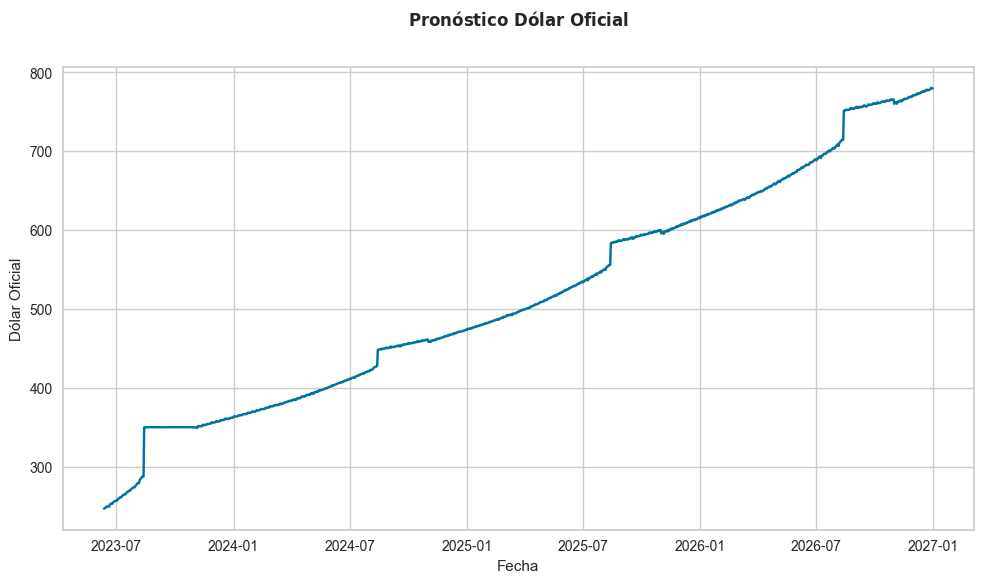

In [106]:
# Crear el gráfico de serie de tiempo
plot.figure(figsize=(10, 6))  # Tamaño de la figura

plot.plot(dolar_futuro['date'], dolar_futuro['dolar_oficial'])
# Personalizar el gráfico
plot.title(r'$\mathbf{Pronóstico\ Dólar\ Oficial}$', pad=30)
plot.xlabel('Fecha')
plot.ylabel('Dólar Oficial')
plot.grid(True)

# Configurar el intervalo de las etiquetas del eje x (por ejemplo, cada año)
# plot.xticks(data.index[::240], data.index.strftime('%b %Y')[::240], rotation=45)

# Mostrar una leyenda
plot.legend()

# Mostrar el gráfico
plot.tight_layout()  # Para ajustar el diseño y evitar cortes en etiquetas
plot.show()

## Pronóstico de la temperatura con Prophet

In [97]:
temp_futuro = pd.read_excel(r"./prophet/predicciones_features/forecast_temp.xlsx")
temp_futuro = temp_futuro[temp_futuro.ds > "2023-06-11"]
temp_futuro = temp_futuro[temp_futuro.ds < "2027-01-01"]
temp_futuro = temp_futuro[["ds", "yhat"]]
temp_futuro.columns = ["date", "temperature_C"]
temp_futuro.reset_index(drop=True, inplace=True)
temp_futuro

,date,temperature_C
0,2023-06-12,12.670170
1,2023-06-13,12.626890
2,2023-06-14,12.699590
3,2023-06-15,12.646862
4,2023-06-16,12.571349
...,...,...
1294,2026-12-27,26.207516
1295,2026-12-28,26.357668
1296,2026-12-29,26.431690
1297,2026-12-30,26.606259


## Feriados Futuros

In [72]:
feriados_futuro = pd.read_excel(r"./prophet/predicciones_features/feriados_futuro.xlsx")
feriados_futuro = feriados_futuro[['fecha', 'is_working']]
feriados_futuro = feriados_futuro[feriados_futuro.fecha < "2027-01-01"]
feriados_futuro.columns = ["date", "is_working"]
feriados_futuro

,date,is_working
0,2023-06-12,1
1,2023-06-13,1
2,2023-06-14,1
3,2023-06-15,1
4,2023-06-16,1
...,...,...
1294,2026-12-27,0
1295,2026-12-28,1
1296,2026-12-29,1
1297,2026-12-30,1


## Generamos dataframe que será el input del modelo. Con las features anteriores + day_of_week	day_of_year	month	year

In [129]:
futuro = pd.merge(dolar_futuro, temp_futuro, on='date', how='inner')
futuro = pd.merge(futuro, feriados_futuro, on='date', how='inner')
futuro["day_of_week"] = futuro["date"].dt.dayofweek
futuro["day_of_year"] = futuro["date"].dt.dayofyear
futuro["month"] = futuro["date"].dt.month
futuro["year"] = futuro["date"].dt.year
futuro['Series'] = np.arange(1,len(futuro)+1)
futuro = futuro[["date" ,"Series", "temperature_C", "day_of_week", "day_of_year", "month", "year", "is_working", "dolar_oficial" ]]
futuro

,date,Series,temperature_C,day_of_week,day_of_year,month,year,is_working,dolar_oficial
0,2023-06-12,1,12.670170,0,163,6,2023,1,246.800
1,2023-06-13,2,12.626890,1,164,6,2023,1,247.100
2,2023-06-14,3,12.699590,2,165,6,2023,1,248.000
3,2023-06-15,4,12.646862,3,166,6,2023,1,248.350
4,2023-06-16,5,12.571349,4,167,6,2023,1,249.450
...,...,...,...,...,...,...,...,...,...
1293,2026-12-27,1294,26.207516,6,361,12,2026,0,777.881
1294,2026-12-28,1295,26.357668,0,362,12,2026,1,779.026
1295,2026-12-29,1296,26.431690,1,363,12,2026,1,780.140
1296,2026-12-30,1297,26.606259,2,364,12,2026,1,779.432


In [130]:
predictions_future = predict_model(final_best, futuro)
predictions_future

,date,Series,temperature_C,day_of_week,day_of_year,month,year,is_working,dolar_oficial,prediction_label
0,2023-06-12,1,12.670170,0,163,6,2023,1,246.800003,379.176431
1,2023-06-13,2,12.626889,1,164,6,2023,1,247.100006,387.773306
2,2023-06-14,3,12.699591,2,165,6,2023,1,248.000000,391.195046
3,2023-06-15,4,12.646862,3,166,6,2023,1,248.350006,391.590268
4,2023-06-16,5,12.571349,4,167,6,2023,1,249.449997,387.773306
...,...,...,...,...,...,...,...,...,...,...
1293,2026-12-27,1294,26.207516,6,361,12,2026,0,777.880981,358.237855
1294,2026-12-28,1295,26.357668,0,362,12,2026,1,779.026001,399.679278
1295,2026-12-29,1296,26.431690,1,363,12,2026,1,780.140015,406.217052
1296,2026-12-30,1297,26.606258,2,364,12,2026,1,779.432007,397.311398


In [131]:
concat_df = pd.concat([datos,predictions_future], axis=0)
concat_df.reset_index(drop=True, inplace=True)
concat_df

,date,Series,demand_GWh,temperature_C,day_of_week,day_of_year,month,year,is_working,uv_index,dolar_oficial,prediction_label
0,2007-01-01,1,277.581153,29.200000,0,1,1,2007,0,3.0,NaN,NaN
1,2007-01-02,2,325.393852,26.010000,1,2,1,2007,1,1.0,NaN,NaN
2,2007-01-03,3,325.492540,25.000000,2,3,1,2007,1,1.0,NaN,NaN
3,2007-01-04,4,334.033576,25.000000,3,4,1,2007,1,1.0,NaN,NaN
4,2007-01-05,5,320.328528,22.600000,4,5,1,2007,1,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7299,2026-12-27,1294,NaN,26.207516,6,361,12,2026,0,NaN,777.880981,358.237855
7300,2026-12-28,1295,NaN,26.357668,0,362,12,2026,1,NaN,779.026001,399.679278
7301,2026-12-29,1296,NaN,26.431690,1,363,12,2026,1,NaN,780.140015,406.217052
7302,2026-12-30,1297,NaN,26.606258,2,364,12,2026,1,NaN,779.432007,397.311398


In [133]:
fig = px.line(concat_df, x=concat_df.date, y=["demand_GWh", "prediction_label"], template = 'plotly_dark')
fig.show()

In [136]:
fig = px.line(predictions_future, x=predictions_future.date, y=["prediction_label"], template = 'plotly_dark', title="Pronóstico de la demanda eléctrica")
# Modificar el tamaño de la figura
fig.update_layout(
    width=800,  # Ancho de la figura en píxeles
    height=600,  # Altura de la figura en píxeles
)

# Modificar las etiquetas de los ejes x y y
fig.update_xaxes(title_text='Eje X', tickvals=[1, 2, 3, 4, 5])  # Etiqueta y ubicación de los ticks en el eje x
fig.update_yaxes(title_text='Eje Y', tickvals=[10, 11, 12, 13, 14])  # Etiqueta y ubicación de los ticks en el eje y

fig.show()

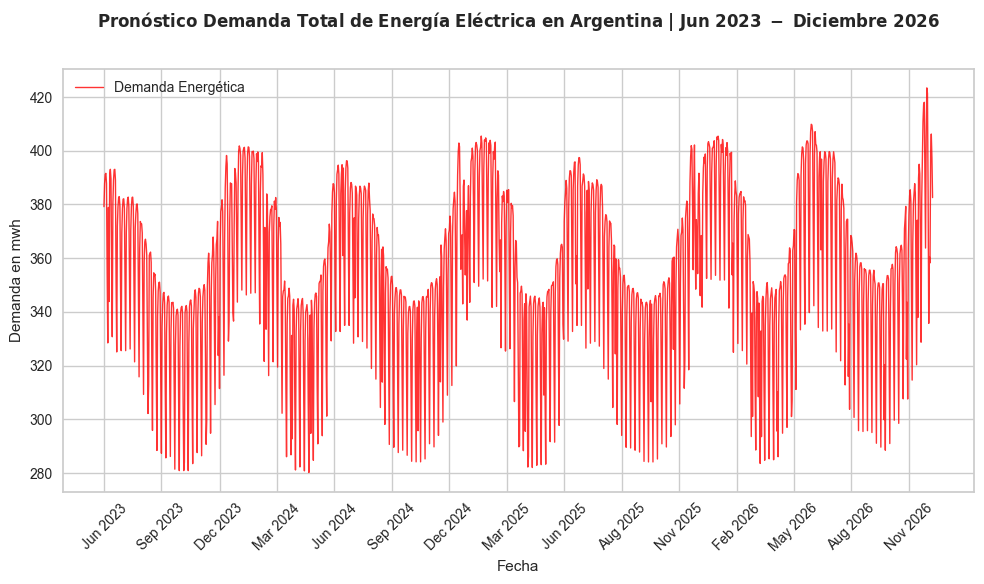

In [152]:

# Crear el gráfico de serie de tiempo
plot.figure(figsize=(10, 6))  # Tamaño de la figura
plot.plot(predictions_future['date'], predictions_future['prediction_label'], linewidth=1, color='red', alpha=0.8, label='Demanda Energética')

# Personalizar el gráfico
plot.title(r'$\mathbf{Pronóstico\ Demanda\ Total\ de\ Energía\ Eléctrica\ en\ Argentina\ | \ Jun \ 2023 \ - \ Diciembre \ 2026}$', pad=30)
plot.xlabel('Fecha')
plot.ylabel('Demanda en mwh')
plot.grid(True)

# Configurar el intervalo de las etiquetas del eje x (por ejemplo, cada año)
plot.xticks(predictions_future['date'][::90], predictions_future['date'].dt.strftime('%b %Y')[::90], rotation=45)

# Mostrar una leyenda
plot.legend()

# Mostrar el gráfico
plot.tight_layout()  # Para ajustar el diseño y evitar cortes en etiquetas
plot.show()